In [3]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import models
from PIL import Image
import torchvision.transforms as transforms
from scipy import ndimage
import cv2
# (Keep your other imports, e.g., for transforms, if needed)

class type_dataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentation=False, crop_augmentation=False, noise=False):
        self.data = []
        self.transform = transform
        self.augmentation = augmentation
        self.crop_augmentation = crop_augmentation
        self.noise = noise

        pathways = ['apoptosis', 'necroptosis', 'necrosis', 'control', 'treatedalive']
        pathways_folder = ['0_Apoptosis', '0_Necroptosis', '0_Necrosis', '0_Control', '0_TreatedAlive']
        # pathways_folder = ['background', 'necrosis']
        for pathway_label, folder in enumerate(pathways_folder):
            pathway_dir = os.path.join(root_dir, folder)
            for fname in os.listdir(pathway_dir):
                image_path = os.path.join(pathway_dir, fname)
                image = Image.open(image_path)
                image = np.array(image)
                # image = cv2.equalizeHist(image)
                self.data.append((image, pathway_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the primary image and label
        image, label = self.data[idx]
        
        # Convert to tensor and repeat for 3 channels if necessary
        image_tensor = torch.from_numpy(image).repeat(3, 1, 1).float()
        
        # Apply any prebuilt transform
        flips = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5)
                            ])
        if self.crop_augmentation:
            crop_size = random.randint(160, 320)
            top = random.randint(0, 320 - crop_size)
            left = random.randint(0, 320 - crop_size)
            image_tensor = image_tensor[:, top:top+crop_size, left:left+crop_size]

        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        if self.noise:
            noise_std = 0.1
            noise = torch.randn_like(image_tensor) * noise_std
            image_tensor = image_tensor + noise
        
        if self.augmentation:
            # ---- CutMix Augmentation Start ----
            image_tensor = flips(image_tensor)
            # Add Gaussian noise (mean=0, std_dev=some_value, e.g. 0.1)
            noise_std = 0.1
            noise = torch.randn_like(image_tensor) * noise_std
            image_tensor = image_tensor + noise
            
            # Sample a random second image (optionally ensure it's different from idx)
            rand_idx = random.randint(0, len(self.data) - 1)
            image2, label2 = self.data[rand_idx]

            """
            if self.noise:
                image2 = ndimage.gaussian_filter(image2, sigma=1)
            """
            image_tensor2 = torch.from_numpy(image2).repeat(3, 1, 1).float()
            if self.crop_augmentation:
                image_tensor2 = image_tensor2[:, top:top+crop_size, left:left+crop_size]
            
            if self.transform:
                image_tensor2 = self.transform(image_tensor2)
            image_tensor2 = flips(image_tensor2)
            
            
            if self.noise:
                noise_std = 0.1
                noise = torch.randn_like(image_tensor2) * noise_std
                image_tensor2 = image_tensor2 + noise
            
            # Sample lambda from a Beta distribution (here using alpha=1.0 for both sides)
            lam = np.random.beta(1.0, 1.0)
            # Get image dimensions (assuming images are of equal size)
            _, H, W = image_tensor.size()
            # Compute the size of the patch to cut and paste
            r = np.sqrt(1 - lam)
            cut_w = int(W * r)
            cut_h = int(H * r)
            
            # Choose a random center point for the patch
            cx = np.random.randint(W)
            cy = np.random.randint(H)
            
            # Calculate the bounding box coordinates and clip to image size
            x1 = np.clip(cx - cut_w // 2, 0, W)
            y1 = np.clip(cy - cut_h // 2, 0, H)
            x2 = np.clip(cx + cut_w // 2, 0, W)
            y2 = np.clip(cy + cut_h // 2, 0, H)
            
            # Replace the region in image_tensor with the corresponding patch from image_tensor2
            image_tensor[:, y1:y2, x1:x2] = image_tensor2[:, y1:y2, x1:x2]
            
            # Adjust lambda to exactly match the pixel ratio of the mixed region
            lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
            # Return a tuple for the label: (label_a, label_b, lam)
            label = (label, label2, lam)
            # ---- CutMix Augmentation End ----
            
        return image_tensor, label


In [4]:
from utils.AugmentedDatasetWrapper import AugmentedDatasetWrapper
from torch.utils.data import DataLoader
from torchvision import models

train_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/train"
val_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/test"

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
train_dataset = type_dataset(train_dir, transform=transform, augmentation=True, crop_augmentation=True, noise=True)
val_dataset = type_dataset(val_dir, transform=transform, augmentation=False, crop_augmentation=False)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=6)
augmented_val_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=1)

train_loader = DataLoader(dataset=augmented_train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=64)

<h1> Confusion Matrix </h1>

In [5]:
import utils

model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)

model.load_state_dict(torch.load(r'C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_22.032991_0.9728_sota.pth'))

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

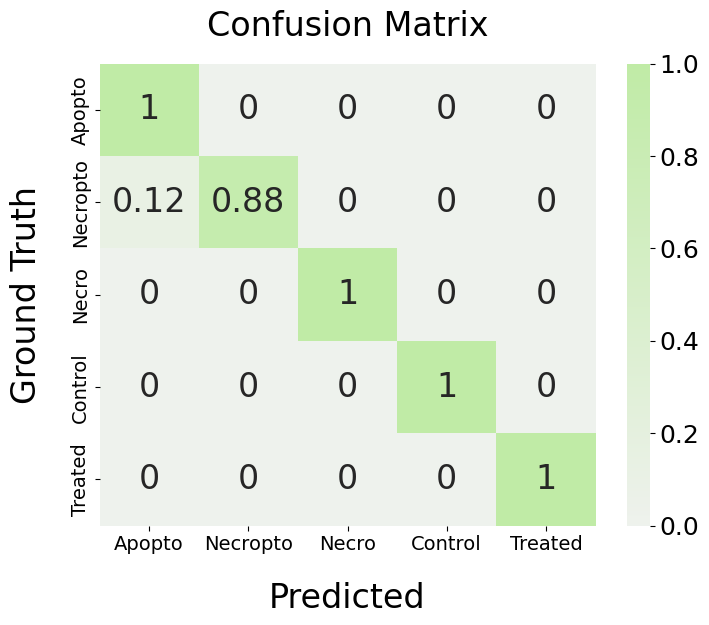

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = model.cuda()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')
# Create a custom colormap using your desired color
custom_cmap = sns.light_palette("#C0EBA6", as_cmap=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap=custom_cmap, xticklabels=["Apopto", "Necropto", "Necro", "Control", "Treated"], 
                                          yticklabels=["Apopto", "Necropto", "Necro", "Control", "Treated"], annot_kws={'size': 24})
plt.xlabel("Predicted", fontsize=24, labelpad=20)
plt.ylabel("Ground Truth", fontsize=24, labelpad=20)
plt.title("Confusion Matrix", fontsize=24, pad=20)

# Adjust colorbar font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick font size

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/figure3/confusion_matrix.svg', format='svg', transparent=True)
plt.show()

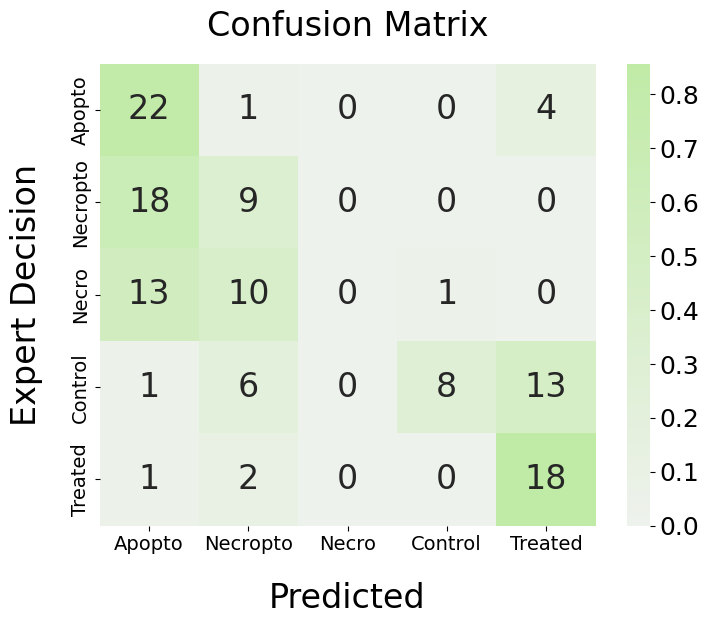

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define confusion matrix data (Expert Decision as columns, Predicted as rows)
cm_data = np.array([
    [22, 18, 13, 1, 1],  # Predicted as apoptosis
    [1,  9, 10,  6, 2],   # Predicted as necroptosis
    [0,  0, 0,  0, 0],   # Predicted as necrosis
    [0,  0, 1,  8, 0],   # Predicted as live (control)
    [4,  0, 0, 13, 18],   # Predicted as live (treated)
])


cm_data = cm_data.T

# Optional normalization (row-wise)
cm_normalized = cm_data / cm_data.sum(axis=1, keepdims=True)

# Create custom colormap
custom_cmap = sns.light_palette("#C0EBA6", as_cmap=True)

# Class labels
x_labels = ["Apopto", "Necropto", "Necro", "Control", "Treated"]
y_labels = ["Apopto", "Necro", "Control", "Treated"]
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=cm_data, fmt='d', cmap=custom_cmap,
            xticklabels=labels, yticklabels=labels, annot_kws={'size': 24})

plt.xlabel("Predicted", fontsize=24, labelpad=20)
plt.ylabel("Expert Decision", fontsize=24, labelpad=20)
plt.title("Confusion Matrix", fontsize=24, pad=20)

# Adjust colorbar font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/figure_supplementary/confusion_matrix_a549.svg', format='svg', transparent=True)
plt.show()


In [31]:
cm_data[3] / np.sum(cm_data[3])

array([0.04761905, 0.0952381 , 0.        , 0.        , 0.85714286])

C:\Users\mw\AppData\Local\Temp\ipykernel_12604\1488728777.py:12: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm_data / cm_data.sum(axis=0, keepdims=True)


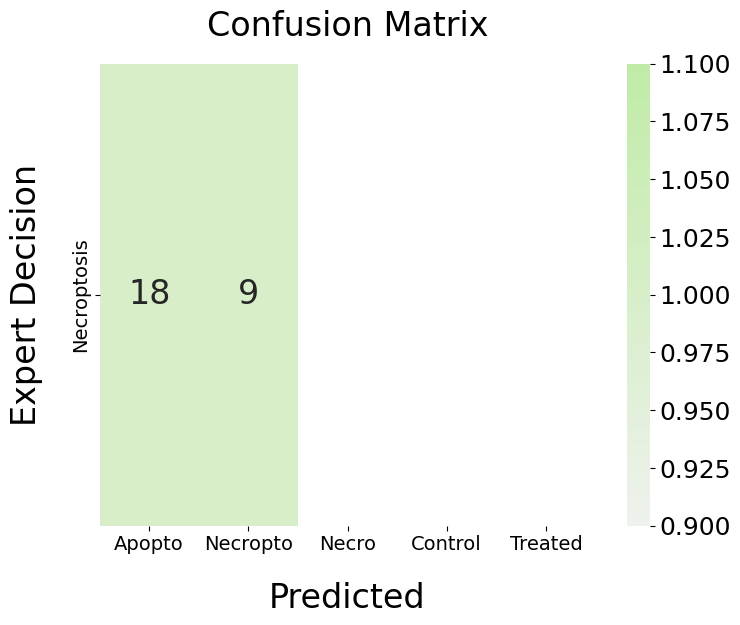

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define confusion matrix data (Expert Decision as columns, Predicted as rows)
cm_data = np.array([
    [18, 9, 0, 0, 0]
])


# Optional normalization (row-wise)
cm_normalized = cm_data / cm_data.sum(axis=0, keepdims=True)

# Create custom colormap
custom_cmap = sns.light_palette("#C0EBA6", as_cmap=True)

# Class labels
x_labels = ["Apopto", "Necropto", "Necro", "Control", "Treated"]
y_labels = ["Necroptosis"]
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=cm_data, fmt='d', cmap=custom_cmap,
            xticklabels=x_labels, yticklabels=y_labels, annot_kws={'size': 24})

plt.xlabel("Predicted", fontsize=24, labelpad=20)
plt.ylabel("Expert Decision", fontsize=24, labelpad=20)
plt.title("Confusion Matrix", fontsize=24, pad=20)

# Adjust colorbar font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/figure_supplementary/confusion_matrix_a549.svg', format='svg', transparent=True)
plt.show()